In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper_functions import (full_training_set_scores,
                              print_scores,
                              kfold_validate_score,
                              kfold_validate_pred,
                              var_plot)

## Import Data and Split into Training/Test Sets

In [2]:
# Import processed data from EDA notebook
bgg = pd.read_csv('./data/bgg_processed.csv', index_col='game_id')

In [3]:
# Split off target column: `avg_rating`
y = bgg['avg_rating']
X = bgg.drop('avg_rating', axis=1).copy()

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Initial linear regression

First let's see how simple linear regression fares. For these first examples, the model will train and predict on the entire training set. This can lead to overfitting, but these examples should give us some indication about which models are able to fit and predict the data the best.

In [5]:
# Fit and score linear regression
linear = LinearRegression().fit(X_train, y_train)

linear_r2, linear_rmse = full_training_set_scores(X_train, y_train, linear)

In [6]:
print_scores(linear_r2, linear_rmse, "Simple Linear Regression")

Simple Linear Regression:

R-squared:     0.5737
RMSE:          0.2901


In [7]:
score_range = y_train.max() - y_train.min()
print(f'The actual range of scores is: {score_range:.5}')

The actual range of scores is: 2.7063


### Linear Regression on the full test set:

The R-squared value is above 0.5, which shows the prediction line fits fairly well to the data. The RMSE is 0.29, which is just over 10% of the total range. These are pretty good initial results. The goal going forward will be to improve these numbers.

## Lasso Regression

After basic linear regression, we will examine related models: lasso and ridge regression.

In [8]:
# Fit and score lasso regression
lasso = Lasso(random_state=42).fit(X_train, y_train)

lasso_r2, lasso_rmse = full_training_set_scores(X_train, y_train, lasso)

In [9]:
print_scores(lasso_r2, lasso_rmse, "Simple Lasso Regression")

Simple Lasso Regression:

R-squared:     0.0
RMSE:          0.4443


### Lasso Regression on the full test set:

The R-squared is zero, so this line does not fit the data at all. The RMSE is a much higher 0.44. Lasso Regression may be removed as a potential model.

## Ridge Regression

In [10]:
# Fit and score ridge regression
ridge = Ridge(random_state=42).fit(X_train, y_train)

ridge_r2, ridge_rmse = full_training_set_scores(X_train, y_train, ridge)

In [11]:
print_scores(ridge_r2, ridge_rmse, "Simple Ridge Regression")

Simple Ridge Regression:

R-squared:     0.5722
RMSE:          0.2906


### Ridge Regression on the full test set:

The R-squared and RMSE scores are extremely close to the scores of simple linear regression. There have been no parameters set, so there may be room for improvement here.

## Support Vector Regression

Using support vector regression, we can look at higher degree predictive lines easily (the line to fit the data can be curved rather than straight). 

Let's test the data on three kernels: linear (straight line), RBF (exponential curve), and poly (polynomial curve). Care must be taken to avoid overfitting, which can be a concern if the degree of the curves gets too high. For these first models, the default degree of 3 will be used.

In [12]:
svr = SVR(kernel='linear').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [13]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - Linear")

Support Vector Regression - Linear:

R-squared:     0.5469
RMSE:          0.299


In [14]:
svr = SVR(kernel='rbf').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [15]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - RBF")

Support Vector Regression - RBF:

R-squared:     0.8941
RMSE:          0.1446


In [16]:
svr = SVR(kernel='poly').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [17]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - Poly")

Support Vector Regression - Poly:

R-squared:     0.8871
RMSE:          0.1493


### Support Vector Regression on the full test set:

Using a linear kernel with Support Vector Regression returns similar results as linear and ridge regression. However, the results are much improved when using RBF or Poly kernels. RBF is a squared exponential kernel, so an exponential or polynomal line seems to be a much better fit for the data.

## Cross-Validation

There are 2000 entries in the original data, so the train/test split leaves 1600 rows in the training data. 8 splits for K-Fold cross validation should be sufficient so each slice is 200 rows. The rows were already shuffled with the train/test split, so they don't need shuffled again.

Cross-validation is important to keep the model from overfitting the data.

In [18]:
# Select model for CV
linear_cv = LinearRegression()

# Return R-squared and RMSE with custom function
linear_cv_r2, linear_cv_rmse = kfold_validate_score(X_train, y_train, model=linear_cv)

# Print Average R-Squared and Average RMSE scores returned from CV
print_scores(linear_cv_r2, linear_cv_rmse, "Linear Regression Cross-Validation")

Linear Regression Cross-Validation:

R-squared:     1.642e+22
RMSE:          2.029e+10


Cross-validation with linear regression returns some truely problematic results. An average R-squared value of 16 sextillion and an average RMSE over 20 billion show that linear regression is not suitable to predict on the dataset.

## Lasso Regression

How do other methods of regression fare? First let's look at Lasso Regression:

In [77]:
# Find mean RMSE through lasso regression over 8 fold
lasso_cv = Lasso(random_state=42)

lasso_cv_r2, lasso_cv_rmse = kfold_validate_score(X_train, y_train, model=lasso_cv)

print_scores(lasso_cv_r2, lasso_cv_rmse, "Lasso Regression Cross-Validation")

Lasso Regression Cross-Validation:

R-squared:     0.006678
RMSE:          0.444


Basic Lasso Regression has a reasonable average RMSE, but an average R-squared in the negative, so it also doesn't seem to fit the data well. This result along with the above result, where lasso regression predicted poorly on the full training set, rule out this model being selected for the final model.

## Ridge Regression

In [80]:
# Find mean RMSE through ridge regression over 8 fold
ridge_cv = Ridge(random_state=42)

ridge_cv_r2, ridge_cv_rmse = kfold_validate_score(X_train, y_train, model=ridge_cv)

print_scores(ridge_cv_r2, ridge_cv_rmse, "Ridge Regression Cross-Validation")

Ridge Regression Cross-Validation:

R-squared:     -0.3423
RMSE:          0.3551


Ridge regression is a sligtly better than lasso with average RMSE, but the average R-squared value is showing it isn't the best fit.

## SVR

In [21]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_linear_cv = SVR(kernel='linear')

svr_linear_cv_r2, svr_linear_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_linear_cv)

print_scores(svr_linear_cv_r2, svr_linear_cv_rmse, "SVR - Linear Cross-Validation")

SVR - Linear Cross-Validation:

R-squared:     -0.2892
RMSE:          0.3695


In [22]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_poly_cv = SVR(kernel='poly')

svr_poly_cv_r2, svr_poly_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_poly_cv)

print_scores(svr_poly_cv_r2, svr_poly_cv_rmse, "SVR - Poly Cross-Validation")

SVR - Poly Cross-Validation:

R-squared:     17.19
RMSE:          0.8899


In [23]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_rbf_cv = SVR(kernel='rbf')

svr_rbf_cv_r2, svr_rbf_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_rbf_cv)

print_scores(svr_rbf_cv_r2, svr_rbf_cv_rmse, "SVR - RBF Cross-Validation")

SVR - RBF Cross-Validation:

R-squared:     -0.4926
RMSE:          0.3146


As suspected from the above results, it seems that SVR overfit on itself, but using cross-validation reveals the model does not work as well as intially thought. A polynomial degree kernel is the worst, but the linear and RBF kernels performed better that the lasso and ridge regression, and definitely better than linear regression.

## Principle Component Regression

Principle Component Analysis (PCA) takes a data set with a high number of features and reduces the number of features by creating new components that are weighted for each variable. This is a method that uses unsupervised clustering, so it will create components with weights on features that are similar to each other, but since this is unsupervised, it may not create components that help make better predictions.

Principle Component Regression is the technique to use PCA to make new components and make predictions using these new components.

In [24]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

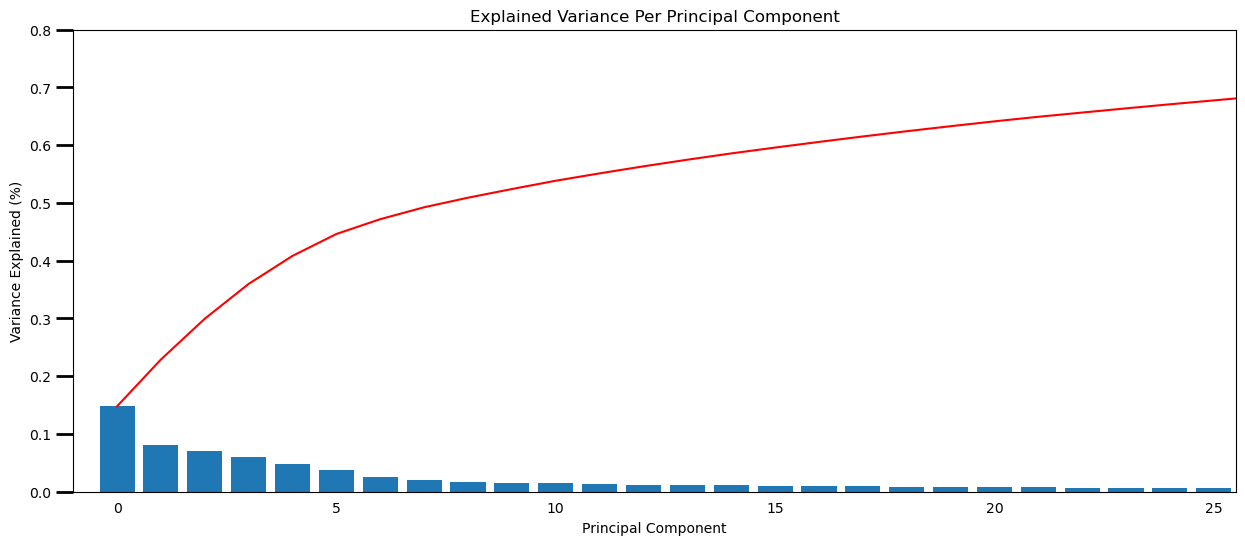

In [25]:
var_plot(pca)
plt.xlim(-1,25.5)
plt.ylim(0, 0.8);

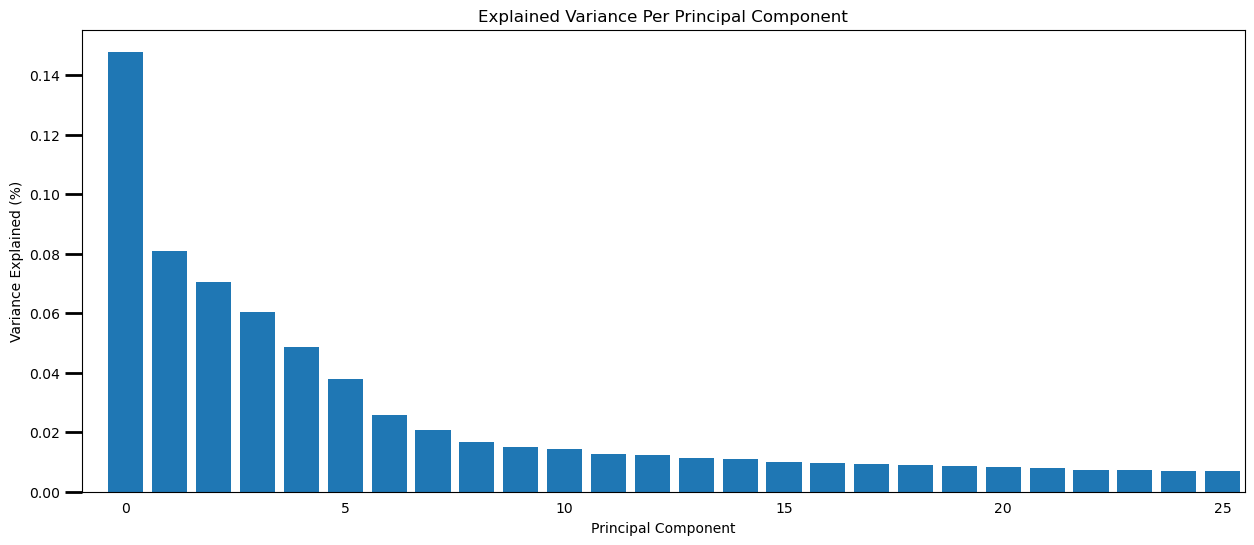

In [26]:
# Bar chart showing variance of PCA transformation with no paramaters
var_plot(pca, scree=False)

# Restrict the x-axis to allow a better view of the important data
plt.xlim(-1,25.5);

In [27]:
# Instatiate
pca_9 = PCA(9, random_state=42)

# Fit & Transform
X_train_reduced_9 = pca_9.fit_transform(X_train)

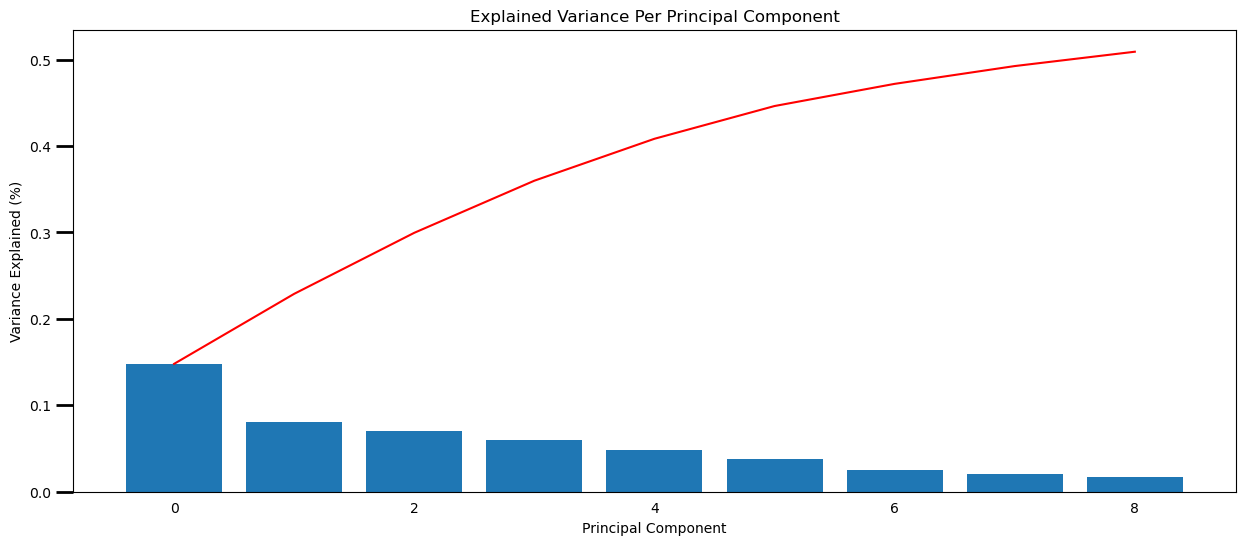

In [28]:
var_plot(pca_9)

In [29]:
# Total percentage of 9 principal components
pca_9.explained_variance_ratio_.sum()

0.5091366269665704

50% of the variance is explained by 9 PCA components.

In [30]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

linear_pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    linear_pca = LinearRegression()
    _, rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=linear_pca)
    linear_pca_rmses.append(rmse)

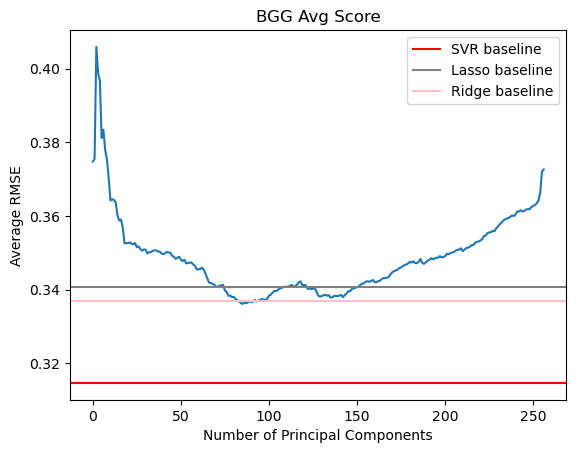

In [31]:
plt.plot(linear_pca_rmses)

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Average RMSE')
plt.title('BGG Avg Score');

In [81]:
# Try it with Lasso regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

lasso_pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    lasso_pca = Lasso(random_state=42)
    _, rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=lasso_pca)
    lasso_pca_rmses.append(rmse)

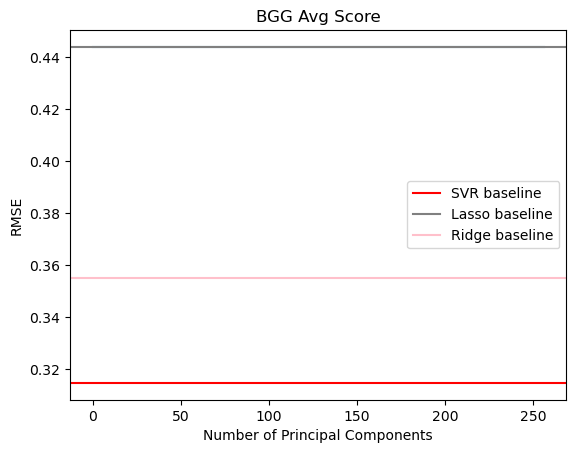

In [82]:
plt.plot(lasso_pca_rmses)

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [83]:
# Try it with Ridge regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

ridge_pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    ridge_pca = Ridge(random_state=42)
    _, rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=ridge_pca)
    ridge_pca_rmses.append(rmse)

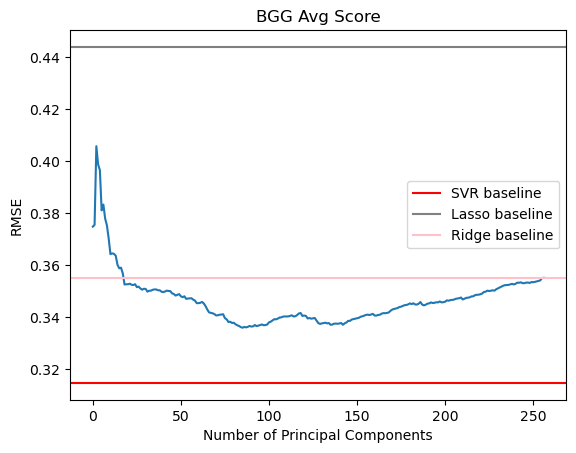

In [84]:
plt.plot(ridge_pca_rmses)

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [36]:
# Try it with SVR - RBF
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

svr_pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    svr_pca = SVR(kernel='rbf')
    _, rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=svr_pca)
    svr_pca_rmses.append(rmse)

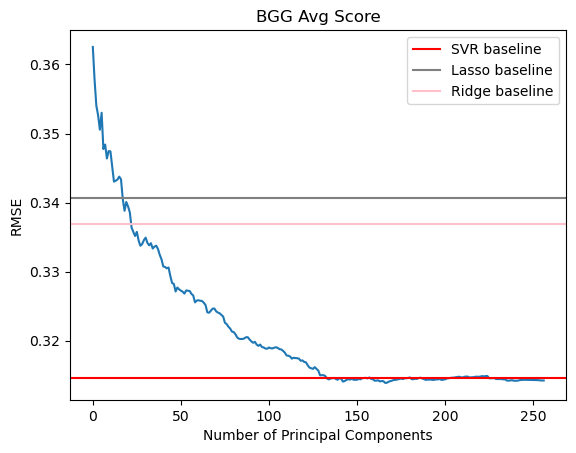

In [37]:
plt.plot(svr_pca_rmses)

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

## Partial Least Squares Regression

In [38]:
pls = PLSRegression(n_components=7)
X_train_pls = pls.fit(X_train, y_train)

In [39]:
X_train_pls = pls.transform(X_train)

In [40]:
# Check mean RMSE for 10 PLS components
linear_pls = LinearRegression()

r2_pls, rmse_pls = kfold_validate_score(X_train_pls, y_train, model=linear_pls)

print_scores(r2_pls, rmse_pls, "Linear Regression - PLS Component Reduction Cross-Validation")

Linear Regression - PLS Component Reduction Cross-Validation:

R-squared:     -0.561
RMSE:          0.2926


In [41]:
linear_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,258):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    linear_pls = LinearRegression()
    
    _, rmse = kfold_validate_score(X_train_pls, y_train, model=linear_pls)
    
    linear_pls_rmses.append(rmse)

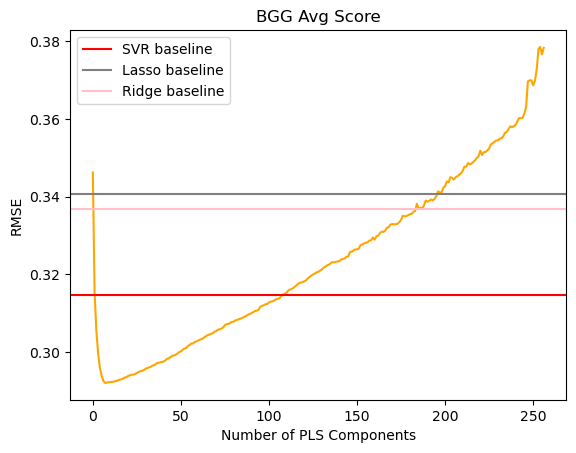

In [42]:
plt.plot(linear_pls_rmses, color='orange')

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [93]:
ridge_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,258):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    ridge_pls = Ridge(random_state=42)
    
    _, rmse = kfold_validate_score(X_train_pls, y_train, model=ridge_pls)
    
    ridge_pls_rmses.append(rmse)

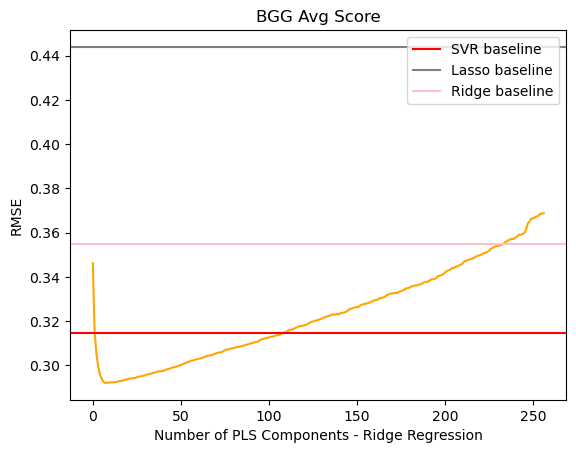

In [94]:
plt.plot(ridge_pls_rmses, color='orange')

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components - Ridge Regression')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [45]:
svc_rbf_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,258):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    svc_rbf_pls = SVR(kernel='rbf')
    
    _, rmse = kfold_validate_score(X_train_pls, y_train, model=svc_rbf_pls)
    
    svc_rbf_pls_rmses.append(rmse)

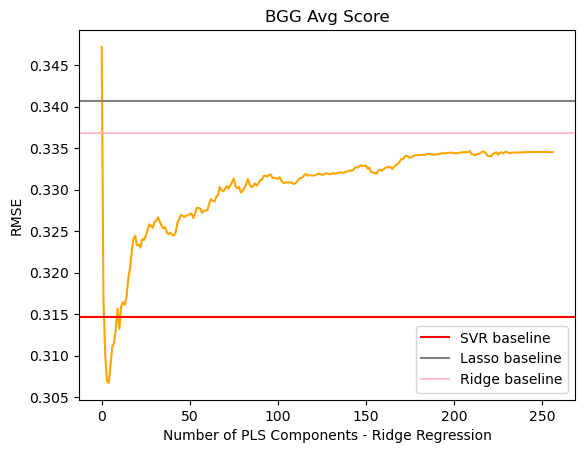

In [46]:
plt.plot(svc_rbf_pls_rmses, color='orange')

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components - Ridge Regression')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

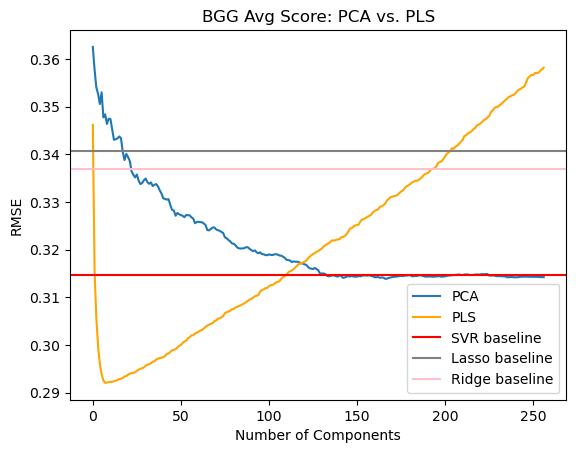

In [51]:
plt.plot(svr_pca_rmses, label='PCA')
plt.plot(ridge_pls_rmses, label='PLS', color='orange')

# add baselines
plt.axhline(svr_rbf_cv_rmse, color='r', label='SVR baseline')
plt.axhline(lasso_cv_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_cv_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score: PCA vs. PLS');

In [99]:
# Instatiate PLS with 7 components
pls = PLSRegression(n_components=7)

# Fit and transform data with the 7 component PLS
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [100]:
# Find mean RMSE through SVR Linear regression over 8 fold
ridge_pls = Ridge(random_state=42)

ridge_pls_r2, ridge_pls_rmse = kfold_validate_score(X_train_pls, y_train, model=ridge_pls)

print_scores(ridge_pls_r2, ridge_pls_rmse, "Ridge Regression (PLS-7 Components) Cross-Validation")

Ridge Regression (PLS-7 Components) Cross-Validation:

R-squared:     -0.561
RMSE:          0.2926


## Final Model??